<a href="https://colab.research.google.com/github/francesco-source/Machine-Learning/blob/main/Clustering_15_01_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering exam 30/01/2021

In [53]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid,GridSearchCV
from sklearn.feature_selection import SelectKBest,mutual_info_classif
from sklearn.metrics import silhouette_score,accuracy_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler ,OneHotEncoder, OrdinalEncoder
from sklearn.metrics.cluster import pair_confusion_matrix
random_state = 42

## 1.  Load the data and separate in X all the columns but the last one, in y the last column, then produce a pairplot of X and comment what you see

In [54]:
data = pd.read_csv("exam_2021_01_15.csv")
data.head()

,A0,A1,A2,y
0,2067.582042,-15.259519,0.020472,2
1,1319.589579,-18.412320,0.521308,0
2,1170.212183,-19.470602,0.814986,0
3,1424.162191,9.867841,0.848751,1
4,1551.069098,11.809364,0.884964,1


In [55]:
X = data.drop("y",axis = 1)
y = data["y"]

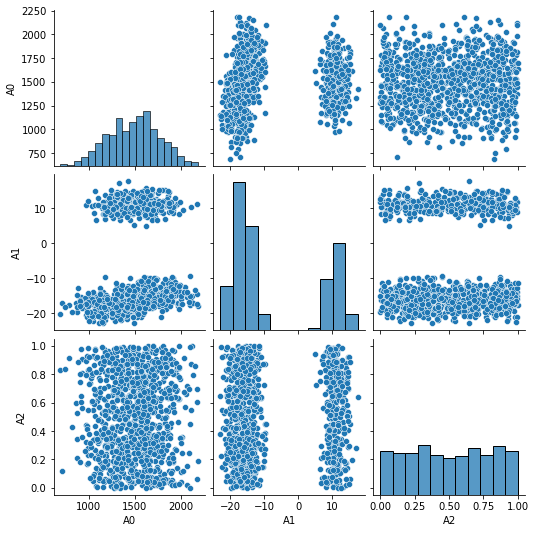

In [56]:
sns.pairplot(X)

The variable A2 seems only noise so I will drop it from the original dataset.

In [57]:
X = X.drop("A2",axis = 1)

##2.  find the best clustering scheme for X with a method of your choice, plot the silhouhette index for an appropriate range of parameters and show the chosen hyperparameter(s)

In [58]:

n_clusters = range(2,11)

silhouette_scores = []

inertia = []

for cluster in  n_clusters:

  km = KMeans(n_clusters = cluster, random_state = random_state)

  y_km = km.fit_predict(X)

  silhouette_scores.append(silhouette_score(X,y_km))
  
  inertia.append(km.inertia_)

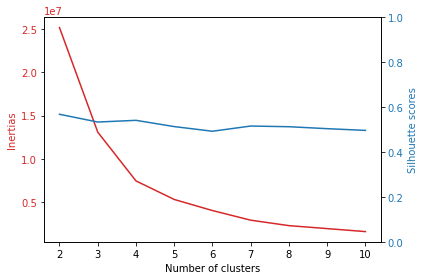

In [59]:
def two_plots(x, y1, y2, xlabel, y1label, y2label):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(y1label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(y2label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


    
two_plots(x=n_clusters, y1=inertia, y2=silhouette_scores
          , xlabel='Number of clusters', y1label='Inertias', y2label='Silhouette scores'
         )

The best number of clusters is equal to 3. A simple consideration on the silhouette is not enough

## 3. Fit the clustering scheme store the cluster labels in y_km and output the silhouette score

In [60]:
km = KMeans(n_clusters = 3, random_state = random_state)

y_km = km.fit_predict(X)

print("The silhouette score is equl to:",silhouette_score(X,y_km).round(2))

The silhouette score is equl to: 0.53


## 4. Use the labels in the last column of the input file as the “gold standard” for the clustering and compare y_km and y; for an effective comparison, each label in y_km must be remapped to the best label in y; compute and apply this re-mapping

In [61]:
def remap(y_true,y_pred):
  y_mapped =y_pred.copy()
  for label in np.unique(y_pred):
    true_l,count = np.unique(y_true[y_pred == label],return_counts = True)
    y_mapped[y_pred == label] = true_l[np.argmax(count)]
    return y_mapped

y_km = remap(y,y_km)

##5.  produce the confusion matrix comparing y and y_km with sklearn.metrics.confusion_matrix

In [62]:
from sklearn.preprocessing import normalize
from sklearn.metrics import pair_confusion_matrix
p_c_m = pair_confusion_matrix(y,y_km)
print("The confusion matrix is ")
cm = confusion_matrix(y, y_km)
cm

The confusion matrix is 


array([[242,  89,   3],
       [ 84, 181,  68],
       [ 19, 150, 164]])

##6.  consider possible pre-processing actions, repeat the fitting and evaluate as before the result of the new fitting

In [63]:
mms = MinMaxScaler()
X_mms = mms.fit_transform(X)
X_mms = pd.DataFrame(X_mms, columns = X.columns)

In [67]:
km = KMeans(n_clusters = 3, random_state = random_state)

y_km_mms = km.fit_predict(X_mms)

print("The silhouette for k = 3 is equal to:",silhouette_score(X_mms,y_km_mms))


The silhouette for k = 3 is equal to: 0.6368846993444691


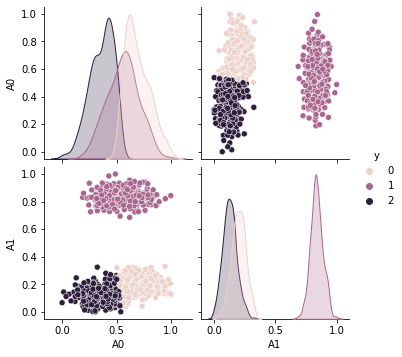

In [68]:
df = X_mms
df["y"] = y_km_mms
sns.pairplot(df,hue="y")

Now lets see the confusion matrix

In [69]:
cm = confusion_matrix(y, y_km_mms)
cm

array([[ 33,   0, 301],
       [  0, 333,   0],
       [296,   0,  37]])

There are labels that we still have to correclty classify.

## We can use also a gaussian scaling

In [70]:
X_rescaled = (X -X.mean())/X.std()

In [71]:

km = KMeans(n_clusters = 3,random_state = random_state)
y_km3 = km.fit_predict(X_rescaled)
silhouette_score_km = silhouette_score(X_rescaled,y_km3)
from sklearn.metrics import pair_confusion_matrix
p_c_m = pair_confusion_matrix(y,y_km3)
print("The pair confusion matrix is ")
p_c_m = p_c_m/ p_c_m.sum()
p_c_m

The pair confusion matrix is 


array([[0.62391592, 0.04341742],
       [0.04339339, 0.28927327]])

Match percentage between the two schemes is : 91.32%


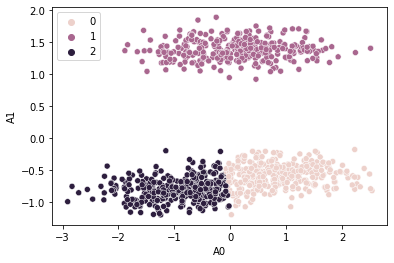

In [72]:
sns.scatterplot(x = X_rescaled["A0"], y = X_rescaled["A1"],hue = y_km3)
print('Match percentage between the two schemes is : {}%'.format(round(sum(p_c_m.diagonal())*100, 2)))